In [1]:
from dotenv import load_dotenv
import os
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


load_dotenv()

True

In [2]:
def get_env_vars() -> dict:
    """
    Obtiene las variables de entorno al momento de la ejecución,
    para soportar cambios dinámicos (ej. en tests).
    """
    return {
        'aws_access_key_id':     os.getenv('AWS_ACCESS_KEY_ID'),
        'aws_secret_access_key': os.getenv('AWS_SECRET_ACCESS_KEY'),
        'aws_region':            os.getenv('AWS_REGION', 'us-east-1'),
        'bucket_name':           os.getenv('BUCKET_NAME'),
        'prefix_ts':             os.getenv('S3_PATH_PROCESS_TIMESERIES'),
        'prefix_output':         os.getenv('S3_PATH_INTERIM'),
        'raw_ts_col':            os.getenv('TS_COL_NAME', 'timestamp'),
        'ts_format':             os.getenv('TS_FORMAT', 'ddMMyyyy HH:mm:ss'),
        'no_sec_regex':          r'^\d{8} \d{2}:\d{2}$',
        'endpoint':              os.getenv('S3_ENDPOINT', 's3.amazonaws.com')
    }

def create_spark_session() -> SparkSession:
    """
    Crea y retorna una SparkSession configurada para S3A.
    """
    env = get_env_vars()
    spark = (
        SparkSession.builder
        .appName('ETL_ProcessTimeSeries')
        .config('spark.hadoop.fs.s3a.access.key', env['aws_access_key_id'])
        .config('spark.hadoop.fs.s3a.secret.key', env['aws_secret_access_key'])
        .config('spark.hadoop.fs.s3a.endpoint', f"http://{env['endpoint']}")
        .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem')
        .config('spark.hadoop.fs.s3a.path.style.access', 'true')
        .getOrCreate()
    )
    return spark

In [3]:
env_aux=get_env_vars()

In [4]:
spark = create_spark_session()
spark.sparkContext.setLogLevel('ERROR')

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/08/08 17:45:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/08/08 17:45:25 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
s3_path = f's3a://{env_aux["bucket_name"]}/{env_aux["prefix_output"]}/laboratory.parquet'
s3_path

's3a://anomaly-pharma-bucket/data/interim/laboratory.parquet'

In [6]:
df_lab = spark.read.parquet(s3_path)

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
                                                                                

In [7]:
df_lab.printSchema()


root
 |-- batch: integer (nullable = true)
 |-- code: integer (nullable = true)
 |-- strength: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- start: string (nullable = true)
 |-- api_code: integer (nullable = true)
 |-- api_batch: integer (nullable = true)
 |-- smcc_batch: integer (nullable = true)
 |-- lactose_batch: integer (nullable = true)
 |-- starch_batch: integer (nullable = true)
 |-- api_water: string (nullable = true)
 |-- api_total_impurities: string (nullable = true)
 |-- api_l_impurity: string (nullable = true)
 |-- api_content: double (nullable = true)
 |-- api_ps01: string (nullable = true)
 |-- api_ps05: string (nullable = true)
 |-- api_ps09: string (nullable = true)
 |-- lactose_water: double (nullable = true)
 |-- lactose_sieve0045: integer (nullable = true)
 |-- lactose_sieve015: integer (nullable = true)
 |-- lactose_sieve025: integer (nullable = true)
 |-- smcc_water: double (nullable = true)
 |-- smcc_td: double (nullable = true)
 |-- smcc_bd:

In [8]:
df_lab.select(df_lab.columns[:10]).show(10, truncate=False)


+-----+----+--------+------+------+--------+---------+----------+-------------+------------+
|batch|code|strength|size  |start |api_code|api_batch|smcc_batch|lactose_batch|starch_batch|
+-----+----+--------+------+------+--------+---------+----------+-------------+------------+
|1    |25  |5MG     |240000|nov.18|5       |2        |1         |2            |1           |
|2    |25  |5MG     |240000|nov.18|5       |2        |1         |2            |1           |
|3    |25  |5MG     |240000|nov.18|5       |2        |1         |2            |1           |
|4    |25  |5MG     |240000|nov.18|5       |2        |1         |2            |1           |
|5    |25  |5MG     |240000|nov.18|5       |2        |1         |2            |1           |
|6    |25  |5MG     |240000|nov.18|5       |2        |1         |2            |1           |
|7    |25  |5MG     |240000|nov.18|5       |2        |1         |2            |1           |
|8    |25  |5MG     |240000|nov.18|5       |2        |1         |2    

In [9]:
numeric_cols = [f.name for f in df_lab.schema.fields if str(f.dataType) in ("IntegerType()", "LongType()", "DoubleType()", "FloatType()")]
df_lab.select(numeric_cols).describe().toPandas()


,summary,batch,code,size,api_code,api_batch,smcc_batch,lactose_batch,starch_batch,api_content,...,tbl_tensile,fct_tensile,tbl_yield,batch_yield,dissolution_av,dissolution_min,resodual_solvent,impurities_total,impurity_o,impurity_l
0,count,1005,1005,1005,1005,1005,1005,1005,1005,1003,...,1005,1005,1005,1005,1005,1005,1005,1005,1005,1005
1,mean,503.0,15.423880597014925,1059289.552238806,3.3771144278606964,123.25671641791045,9.25273631840796,11.06268656716418,9.438805970149254,94.41804586241261,...,1.2880196058776108,1.6704000769711422,98.32322686567157,98.25627661691529,90.64981094527366,85.58905472636816,0.047721393034826226,0.13888557213930336,0.053004975124377435,0.07303482587064584
2,stddev,290.2628119480689,7.1030706329029,711428.5686610213,1.3523160124212803,72.39926211327014,5.113045281134975,5.81050795846003,4.491635272091247,0.39892991832008123,...,0.3105857205255472,0.3728637692430296,1.0780713062267302,1.1285944627081415,3.365708931407941,4.234331276195066,0.04351445688753202,0.09888900696237161,0.009537354486542386,0.02983760463731226
3,min,1,1,240000,1,1,1,1,1,93.3,...,0.786348982,1.040339703,87.973,87.973,82.5,74,0.0,0.05,0.0,0.05
4,max,1005,25,4800000,5,254,18,22,17,95.6,...,2.401744627,3.037157302,100.805,100.909,102.67,100,0.24,0.6,0.16,0.2


In [10]:
total_rows = df_lab.count()
unique_lots = df_lab.select(["batch"]).distinct().count()
print(f"Total de filas: {total_rows}")
print(f"Lotes únicos: {unique_lots}")

[Stage 8:>                                                          (0 + 1) / 1]

Total de filas: 1005
Lotes únicos: 1005


In [11]:
null_counts = {col: df_lab.filter(df_lab[col].isNull()).count() for col in df_lab.columns}
print("Valores nulos por columna:")
for col, cnt in null_counts.items():
    print(f"  {col}: {cnt}")

Valores nulos por columna:
  batch: 0
  code: 0
  strength: 0
  size: 0
  start: 0
  api_code: 0
  api_batch: 0
  smcc_batch: 0
  lactose_batch: 0
  starch_batch: 0
  api_water: 0
  api_total_impurities: 5
  api_l_impurity: 9
  api_content: 2
  api_ps01: 0
  api_ps05: 0
  api_ps09: 0
  lactose_water: 0
  lactose_sieve0045: 0
  lactose_sieve015: 0
  lactose_sieve025: 0
  smcc_water: 0
  smcc_td: 0
  smcc_bd: 0
  smcc_ps01: 0
  smcc_ps05: 0
  smcc_ps09: 0
  starch_ph: 0
  starch_water: 0
  tbl_min_thickness: 0
  tbl_max_thickness: 0
  fct_min_thickness: 0
  fct_max_thickness: 0
  tbl_min_weight: 10
  tbl_max_weight: 10
  tbl_rsd_weight: 0
  fct_rsd_weight: 0
  tbl_min_hardness: 0
  tbl_max_hardness: 0
  tbl_av_hardness: 0
  fct_min_hardness: 0
  fct_max_hardness: 0
  fct_av_hardness: 0
  tbl_max_diameter: 0
  fct_max_diameter: 0
  tbl_tensile: 0
  fct_tensile: 0
  tbl_yield: 0
  batch_yield: 0
  dissolution_av: 0
  dissolution_min: 0
  resodual_solvent: 0
  impurities_total: 0
  impurity

In [12]:
df_lab.groupBy("batch").count().orderBy("count", ascending=False).show(10)

[Stage 179:>                                                        (0 + 1) / 1]

+-----+-----+
|batch|count|
+-----+-----+
|  148|    1|
|  463|    1|
|  471|    1|
|  496|    1|
|  833|    1|
|  243|    1|
|  392|    1|
|  540|    1|
|  623|    1|
|  737|    1|
+-----+-----+
only showing top 10 rows


In [13]:
df_pd = df_lab.select(numeric_cols).toPandas()


In [14]:
stats = df_pd[numeric_cols].describe(percentiles=[0.01, 0.05, 0.95, 0.99]).T
stats = stats.rename(columns={
    '1%': 'p1', '5%': 'p5', '95%': 'p95', '99%': 'p99'
})
stats

,count,mean,std,min,p1,p5,50%,p95,p99,max
batch,1005.0,5.030000e+02,290.262812,1.000000,11.040000,51.200000,503.000000,9.548000e+02,9.949600e+02,1.005000e+03
code,1005.0,1.542388e+01,7.103071,1.000000,1.000000,1.000000,17.000000,2.300000e+01,2.500000e+01,2.500000e+01
size,1005.0,1.059290e+06,711428.568661,240000.000000,240000.000000,240000.000000,960000.000000,1.920000e+06,4.800000e+06,4.800000e+06
api_code,1005.0,3.377114e+00,1.352316,1.000000,1.000000,1.000000,3.000000,5.000000e+00,5.000000e+00,5.000000e+00
api_batch,1005.0,1.232567e+02,72.399262,1.000000,2.000000,8.000000,126.000000,2.390000e+02,2.520000e+02,2.540000e+02
smcc_batch,1005.0,9.252736e+00,5.113045,1.000000,1.000000,2.000000,9.000000,1.800000e+01,1.800000e+01,1.800000e+01
lactose_batch,1005.0,1.106269e+01,5.810508,1.000000,1.000000,3.000000,10.000000,2.000000e+01,2.200000e+01,2.200000e+01
starch_batch,1005.0,9.438806e+00,4.491635,1.000000,1.000000,2.000000,10.000000,1.600000e+01,1.700000e+01,1.700000e+01
api_content,1003.0,9.441805e+01,0.398930,93.300000,93.500000,93.800000,94.400000,9.510000e+01,9.550000e+01,9.560000e+01
lactose_water,1005.0,5.414945e-02,0.007891,0.049500,0.049500,0.049500,0.050000,8.000000e-02,8.000000e-02,8.000000e-02


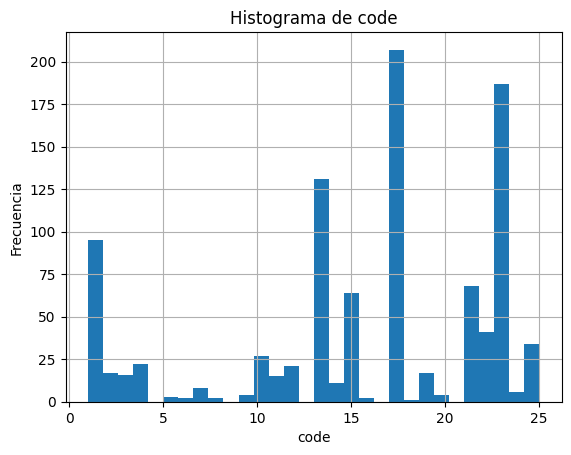

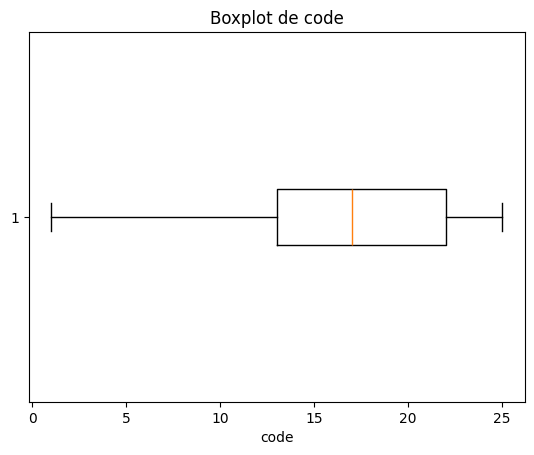

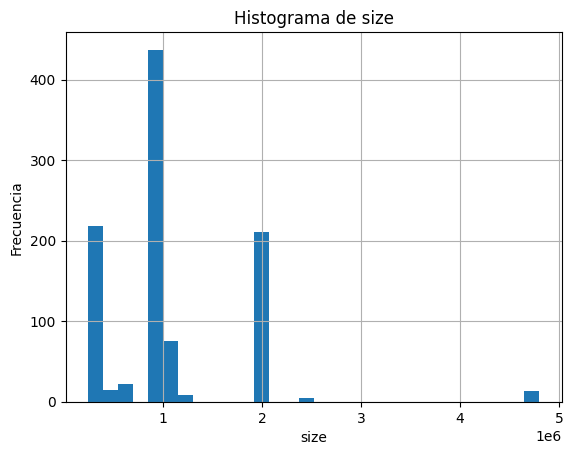

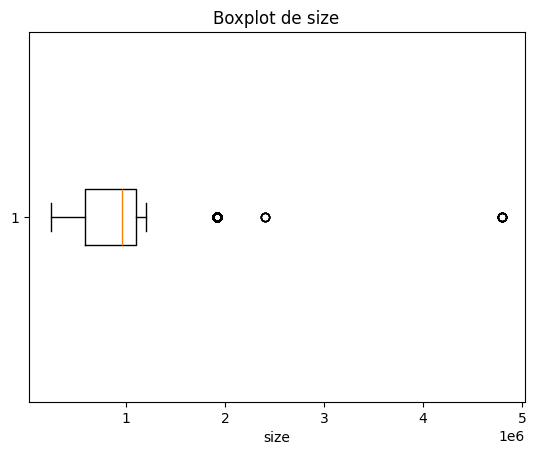

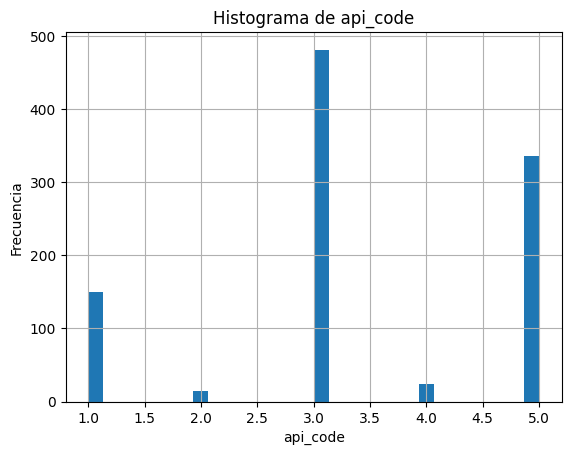

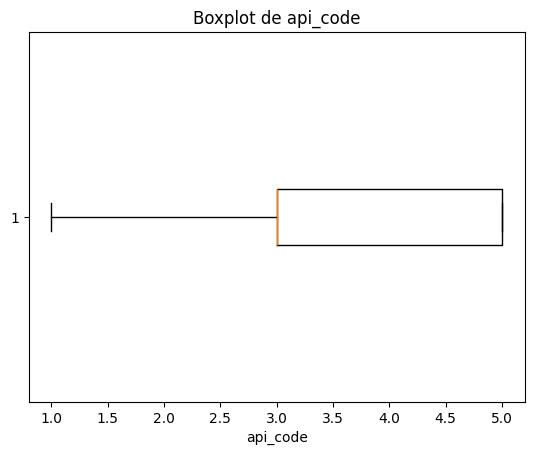

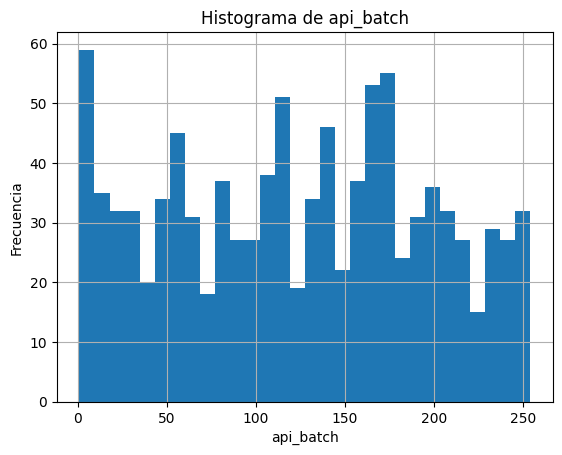

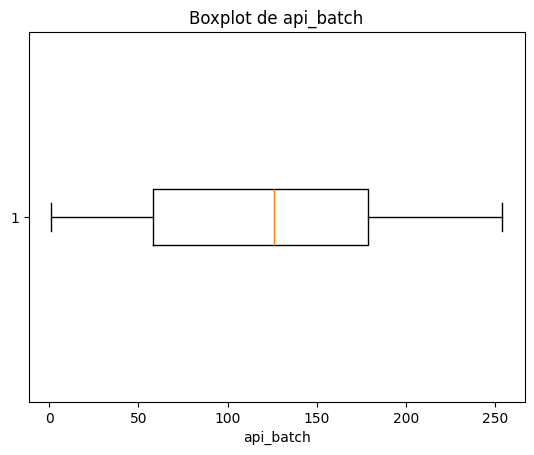

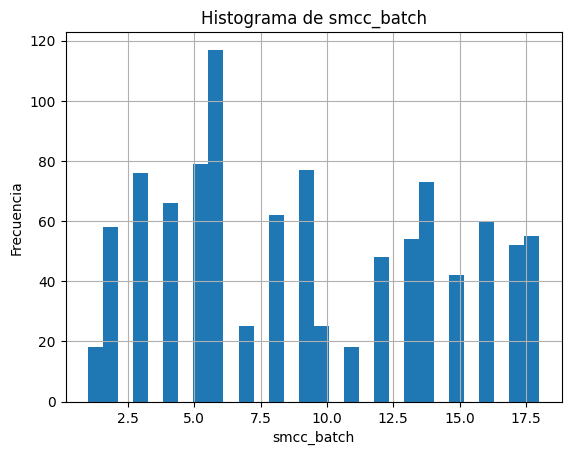

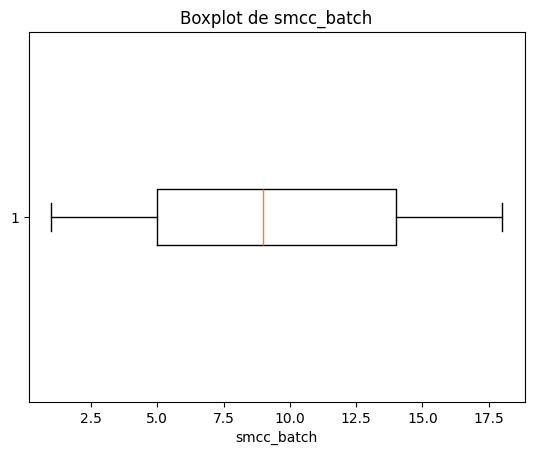

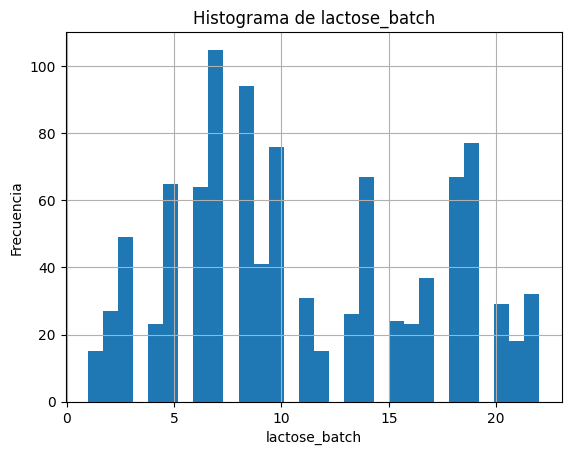

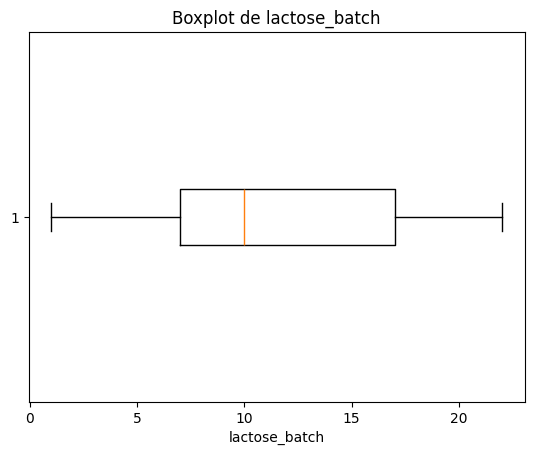

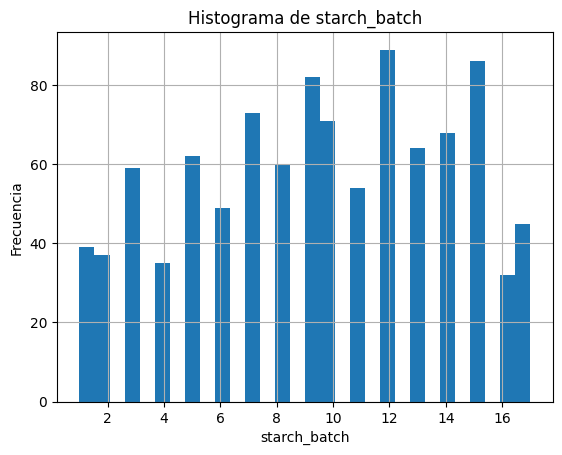

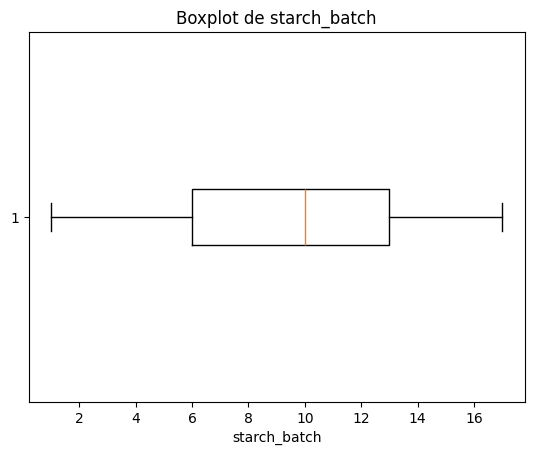

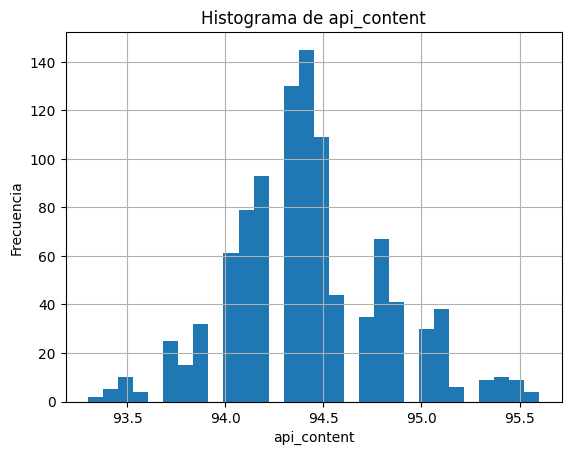

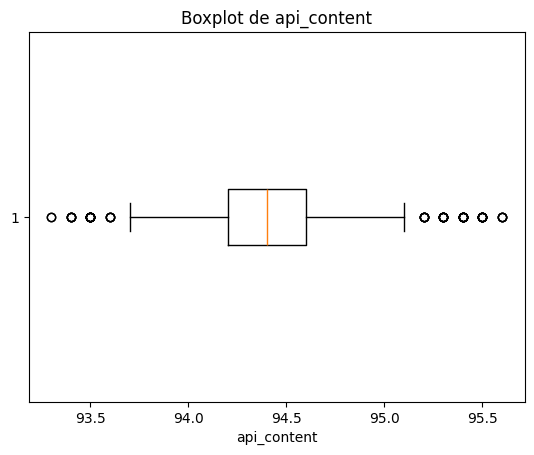

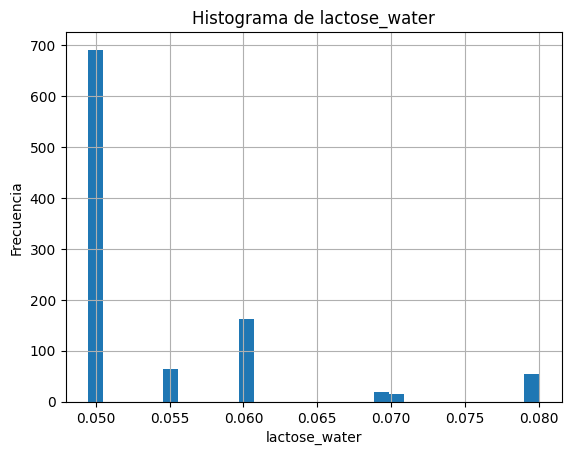

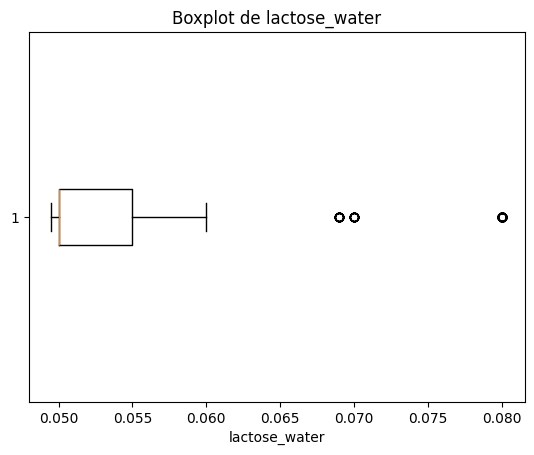

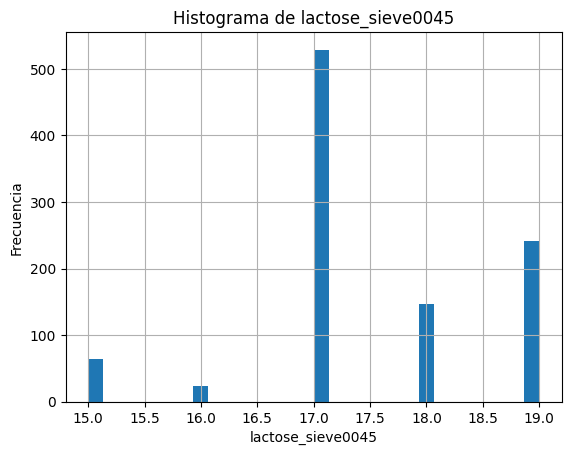

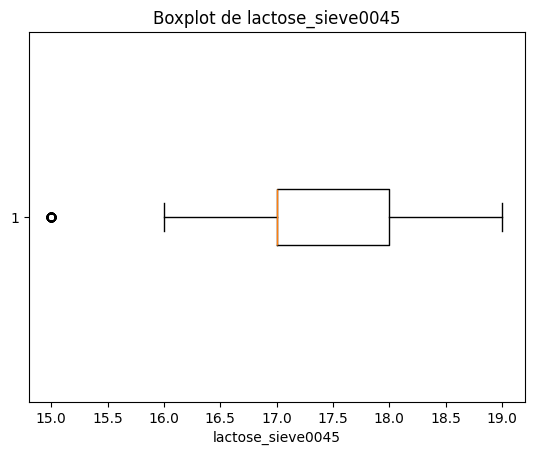

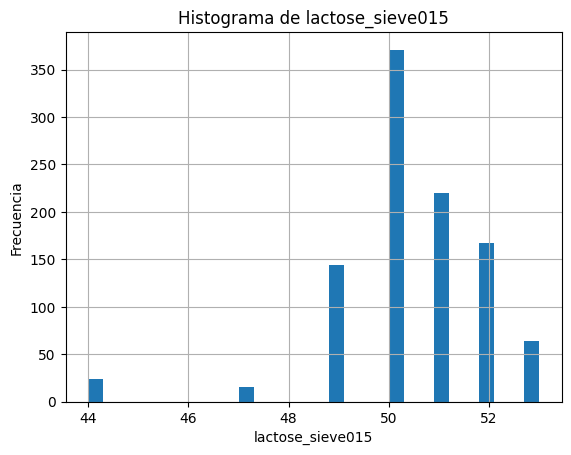

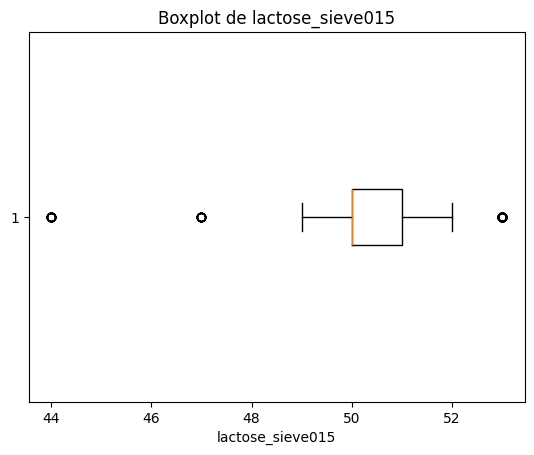

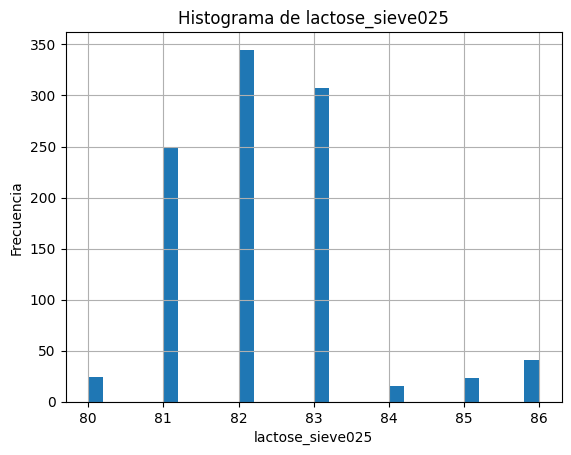

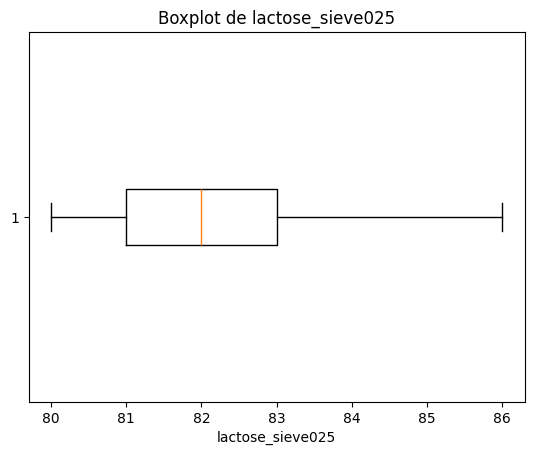

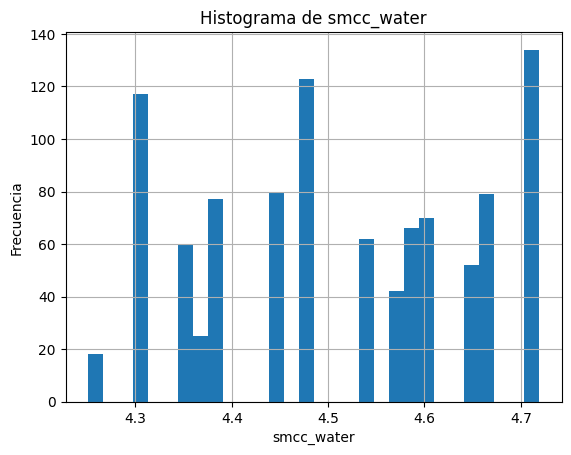

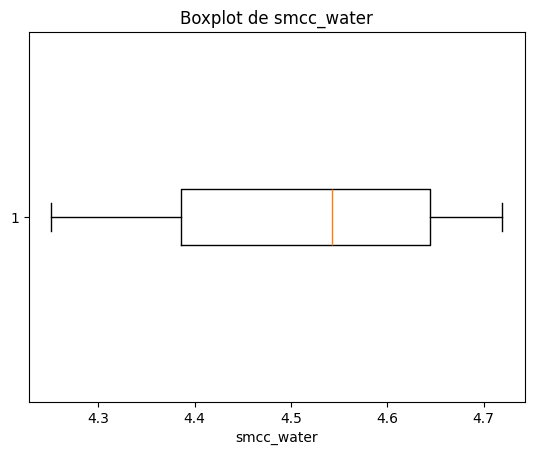

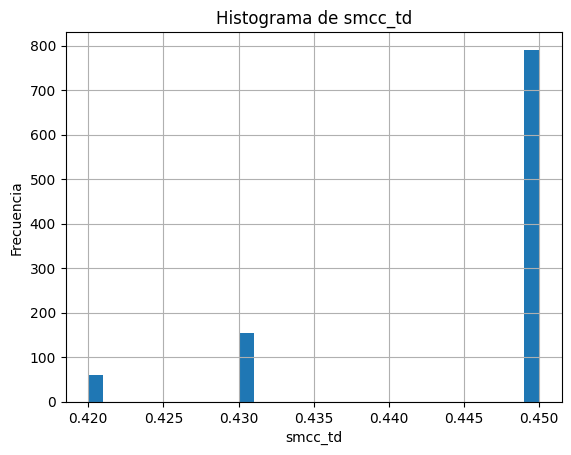

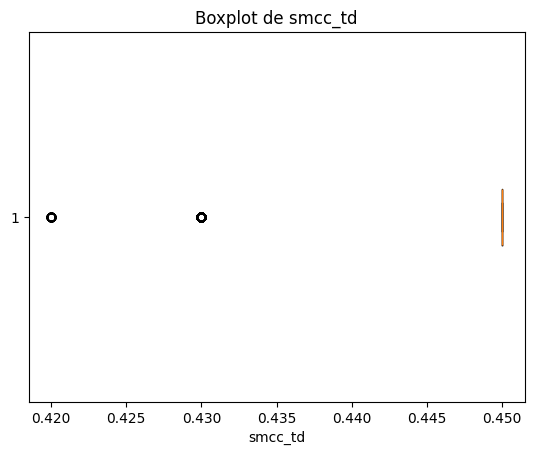

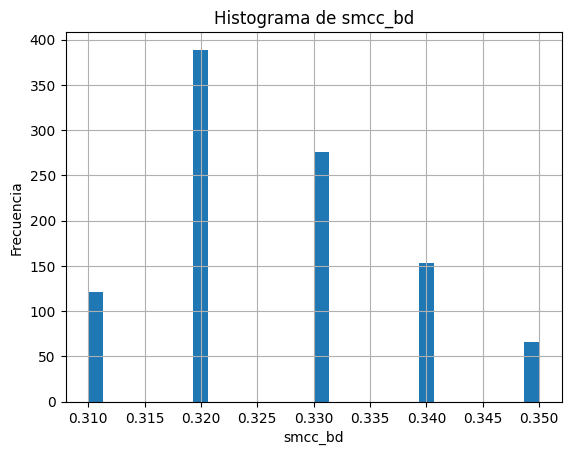

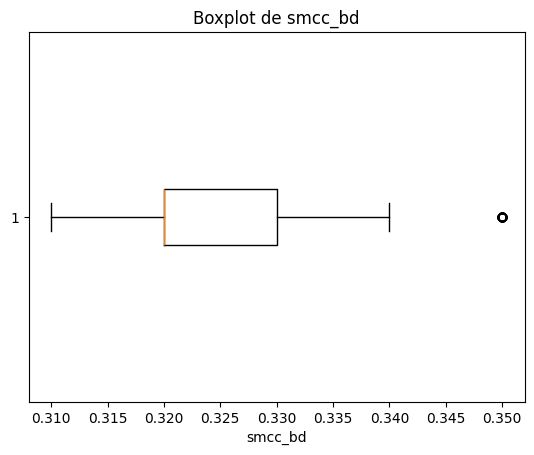

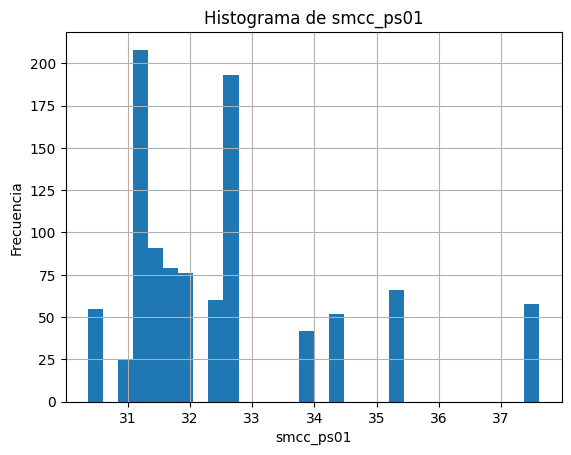

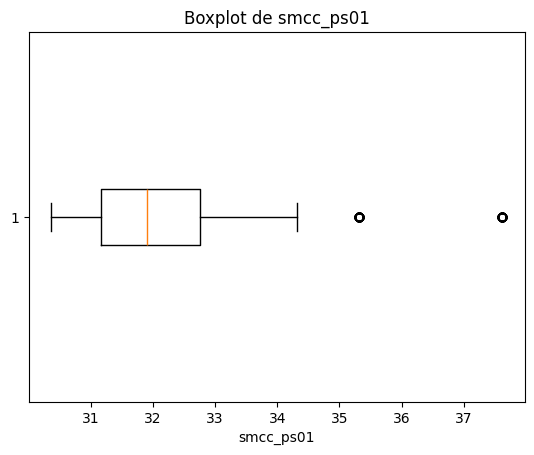

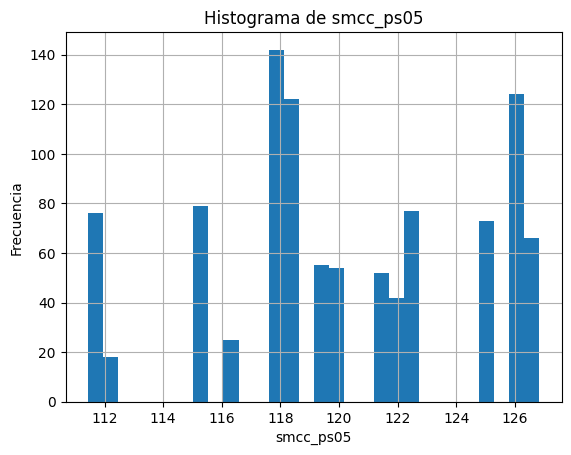

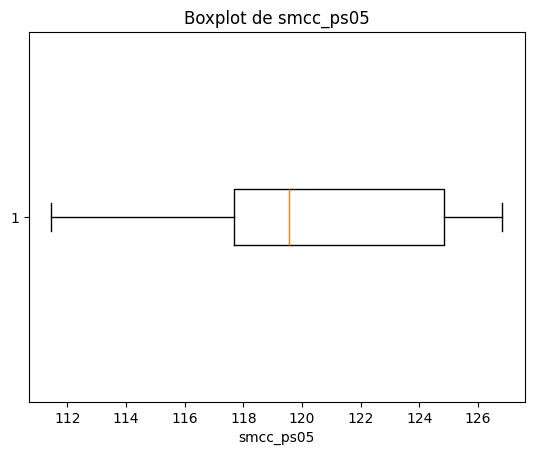

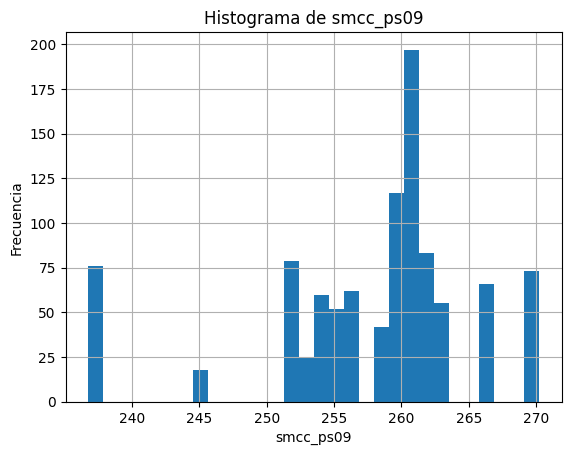

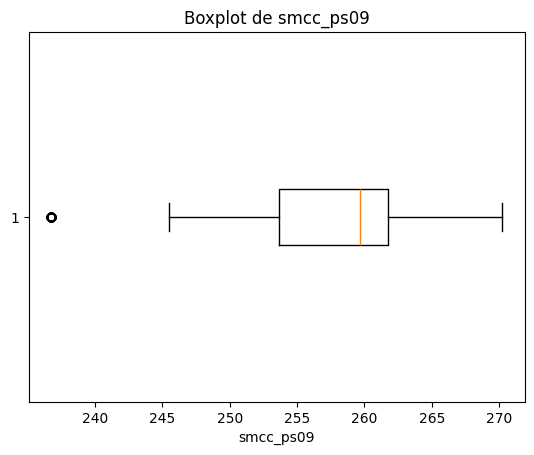

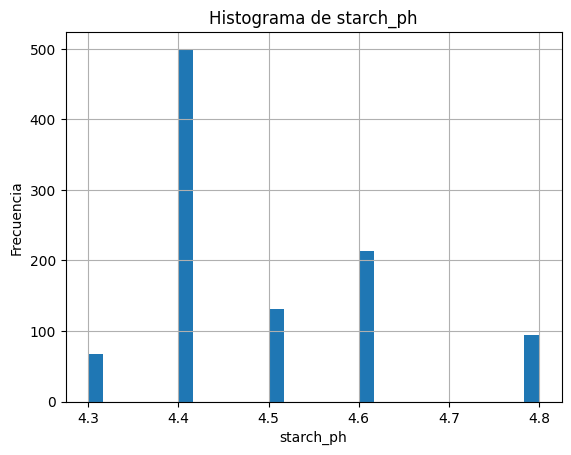

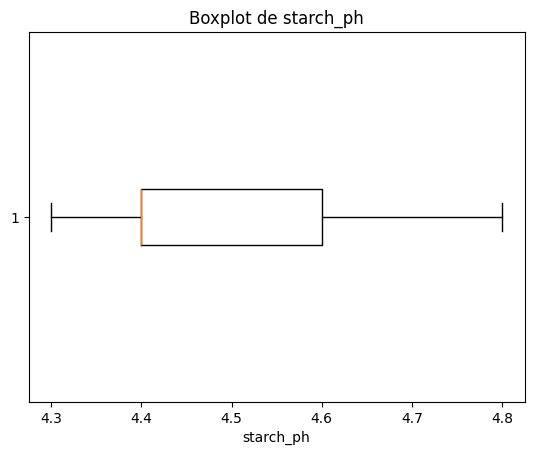

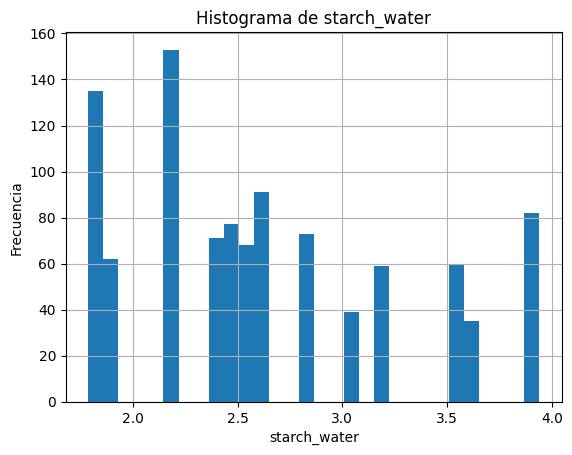

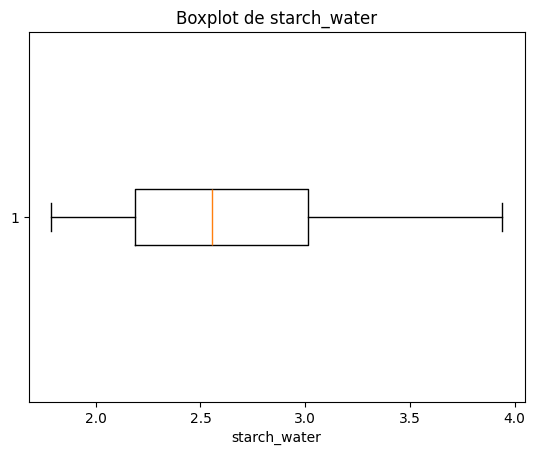

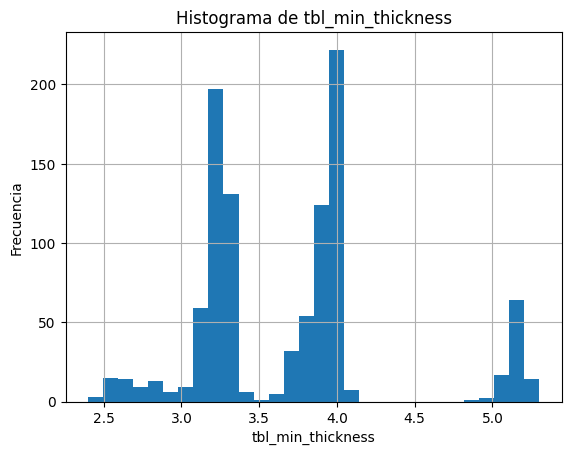

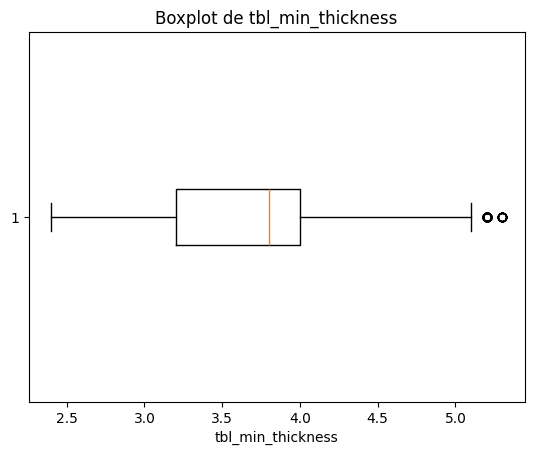

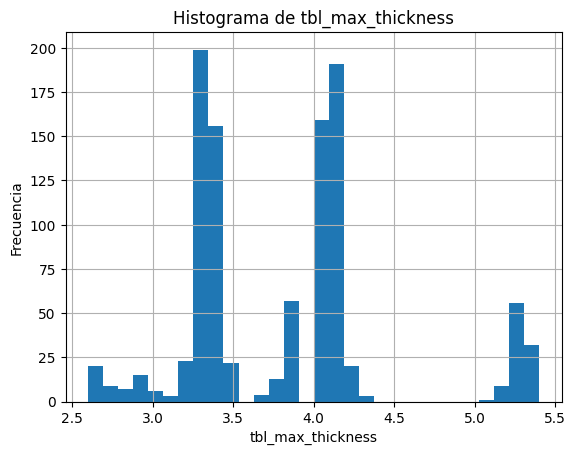

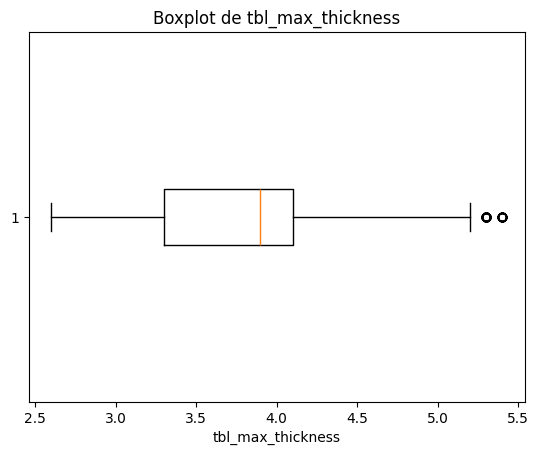

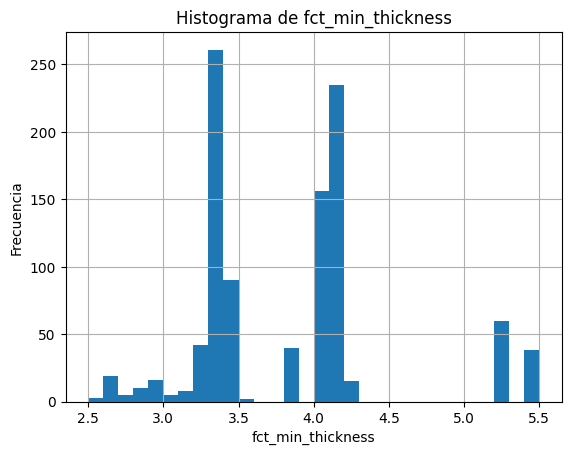

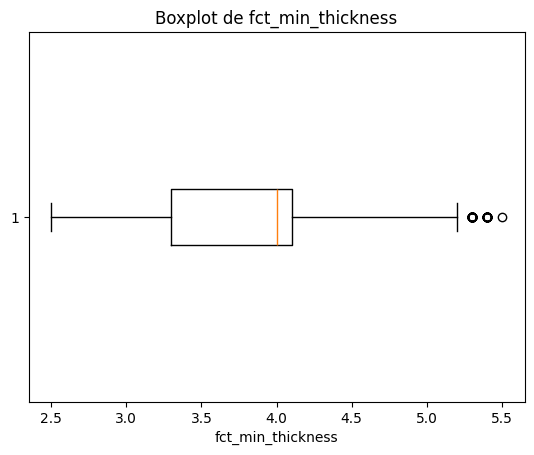

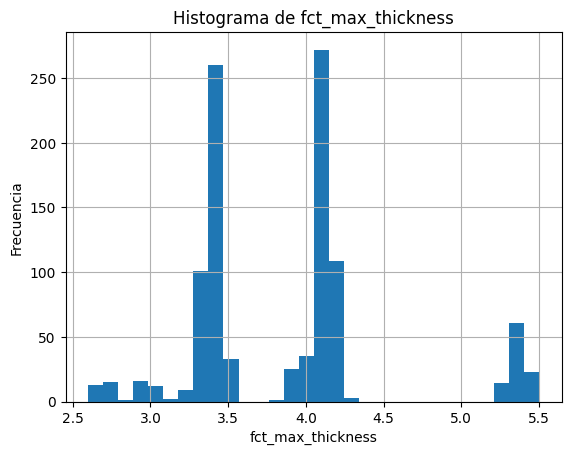

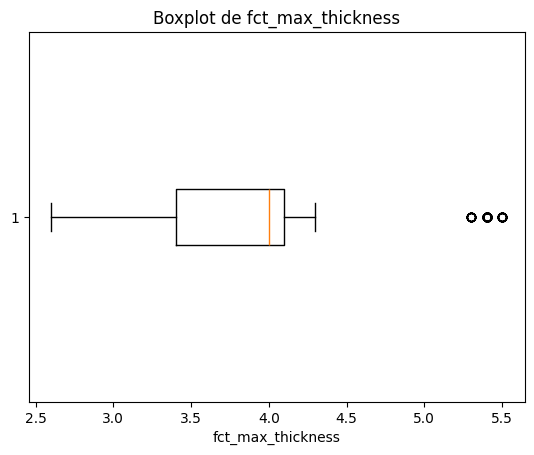

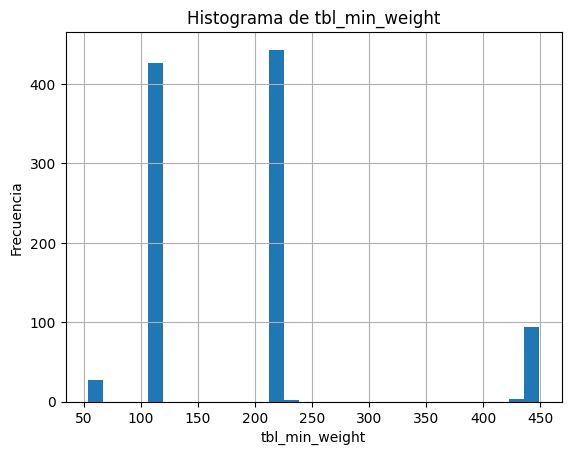

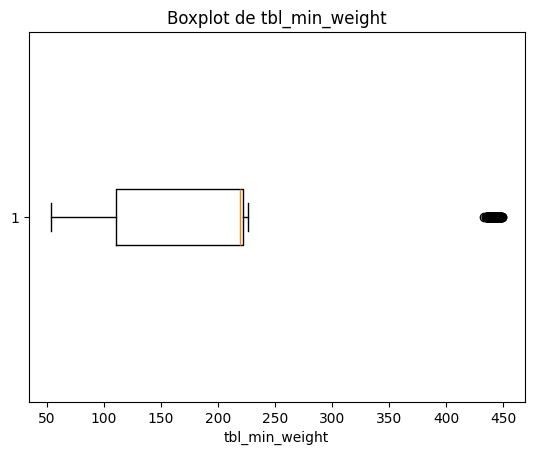

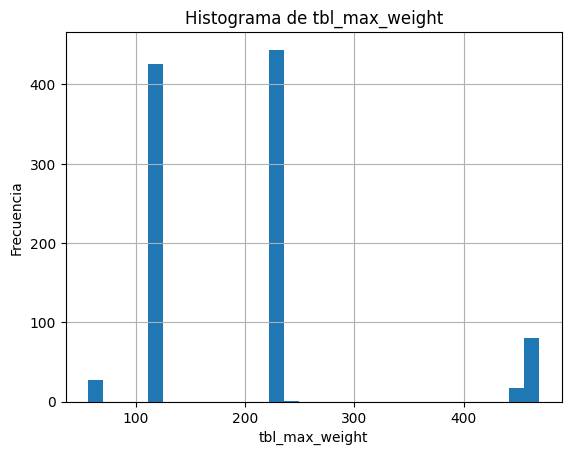

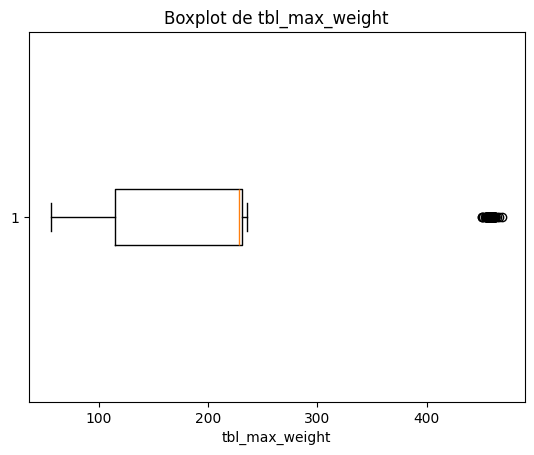

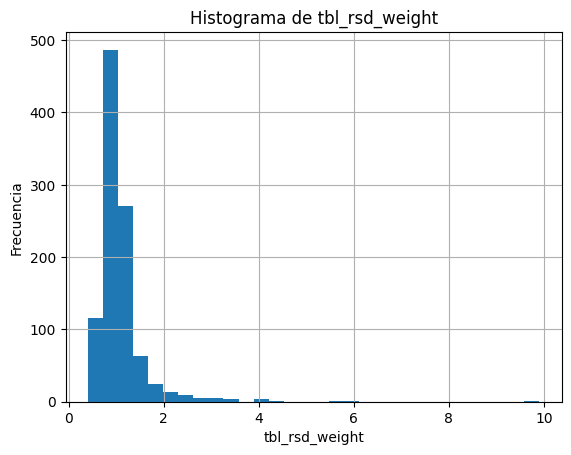

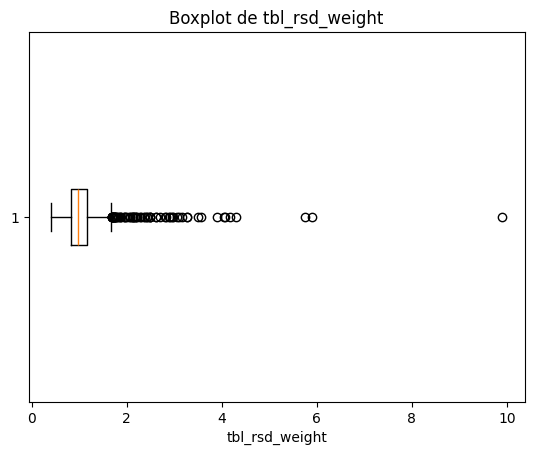

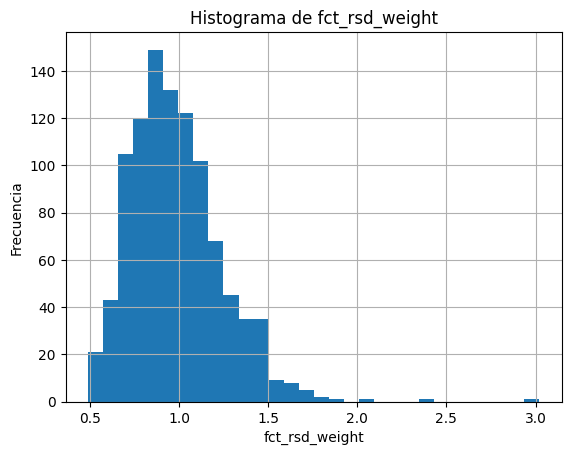

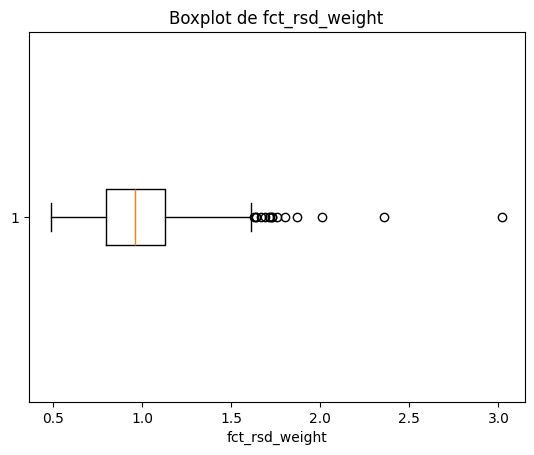

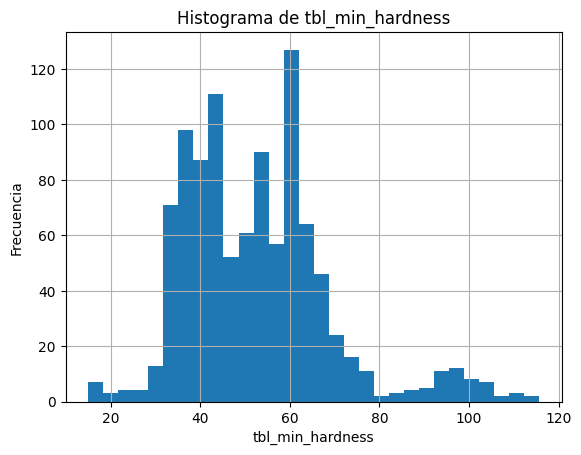

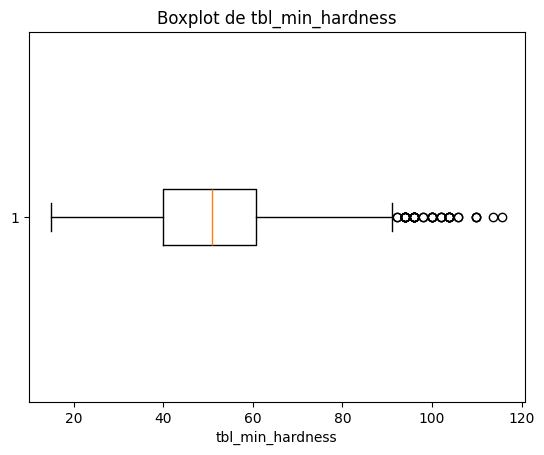

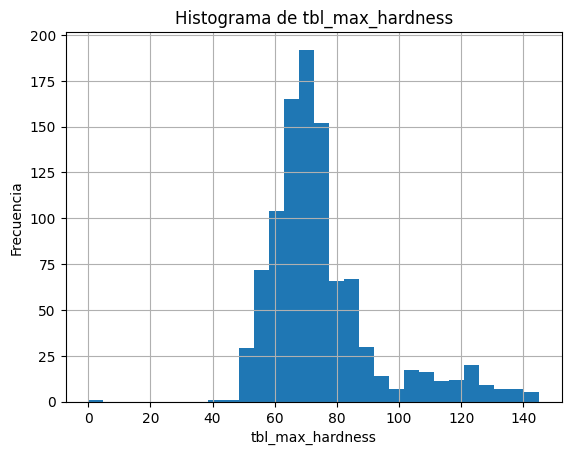

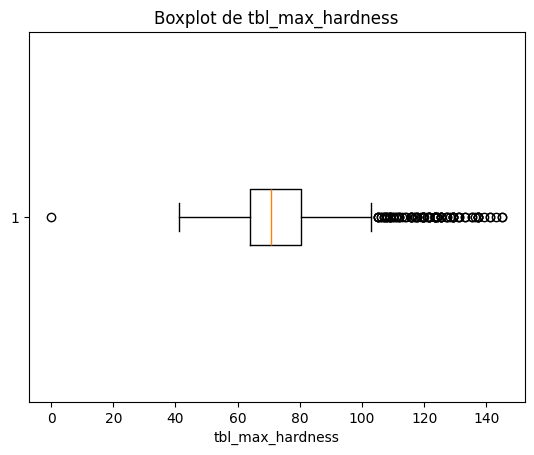

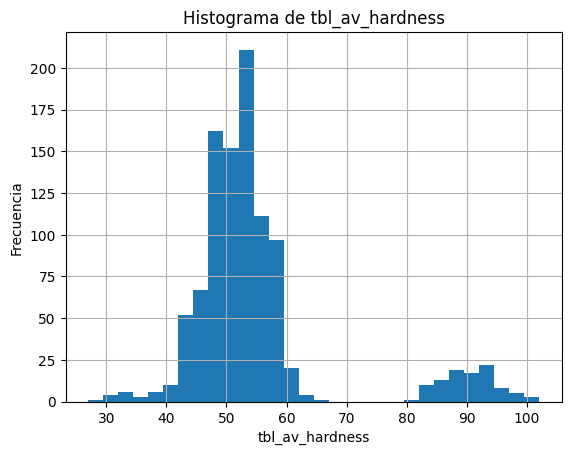

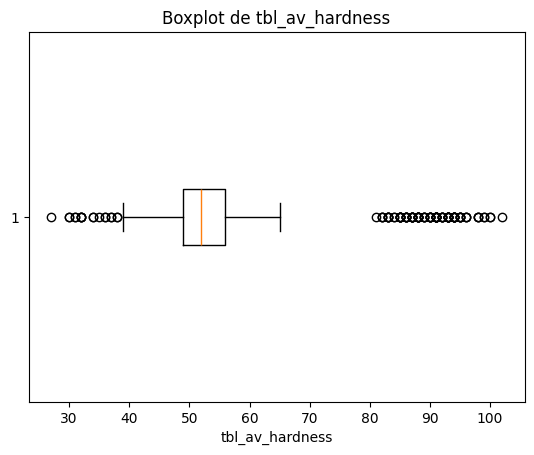

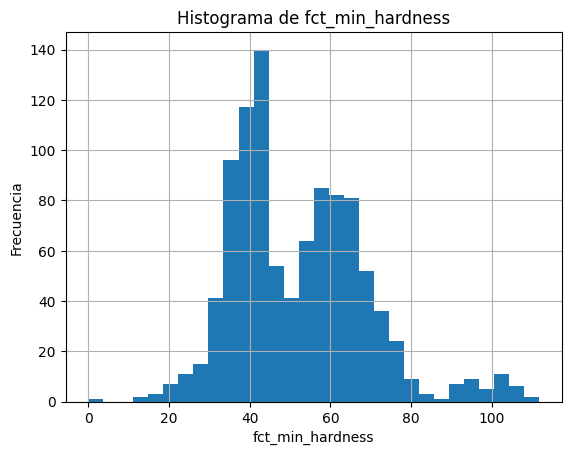

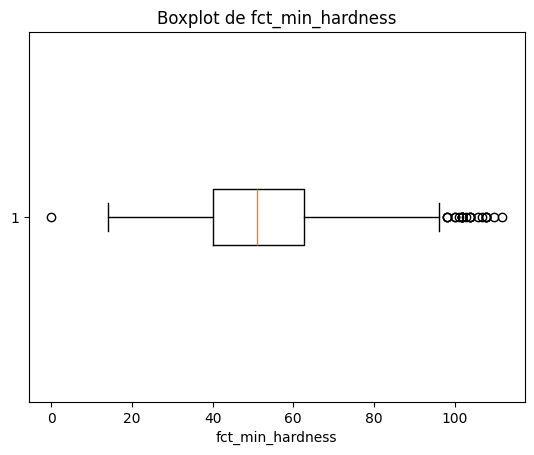

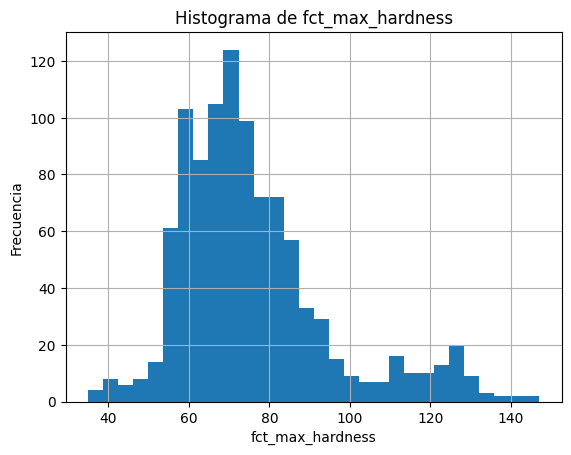

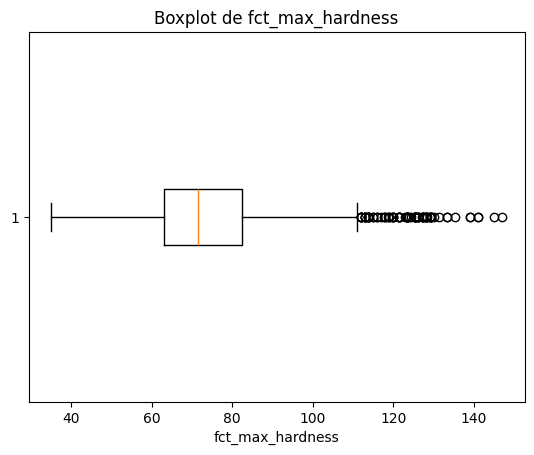

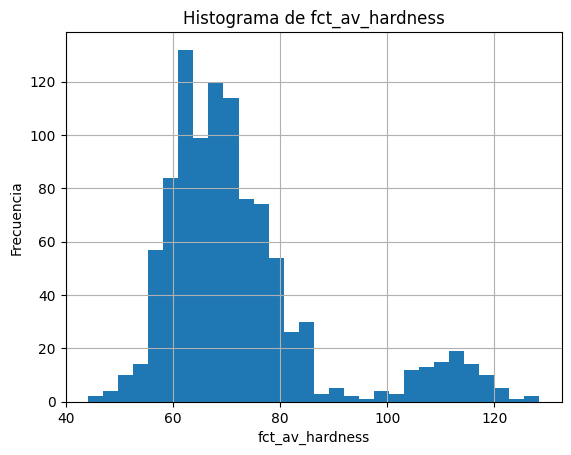

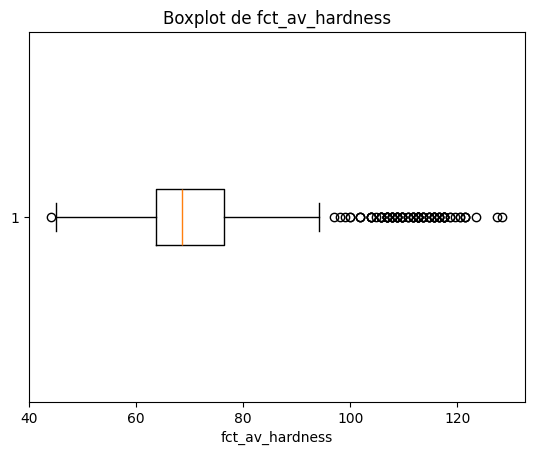

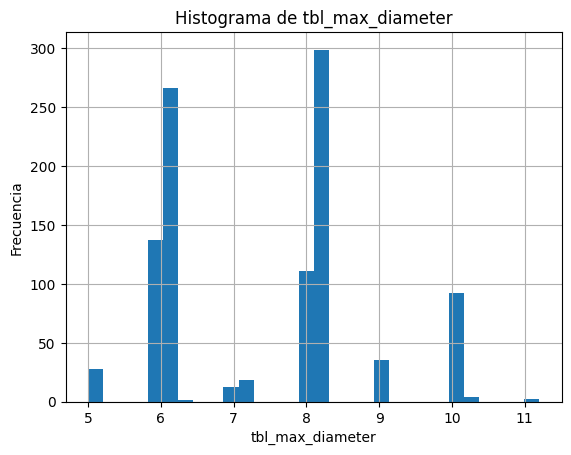

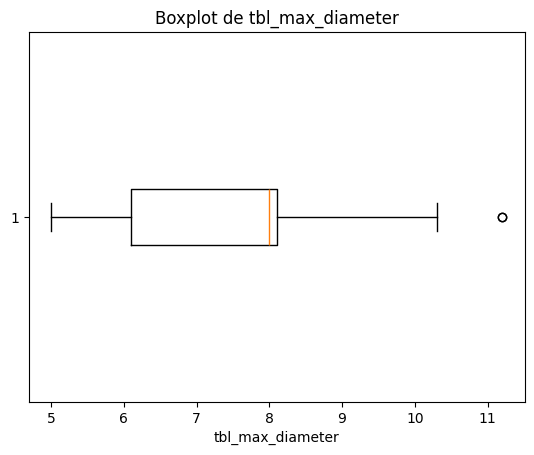

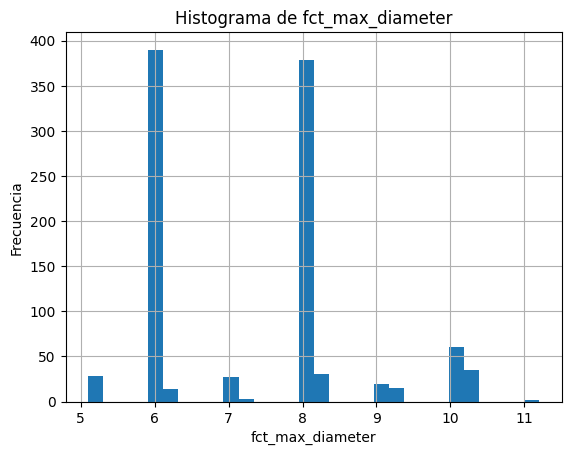

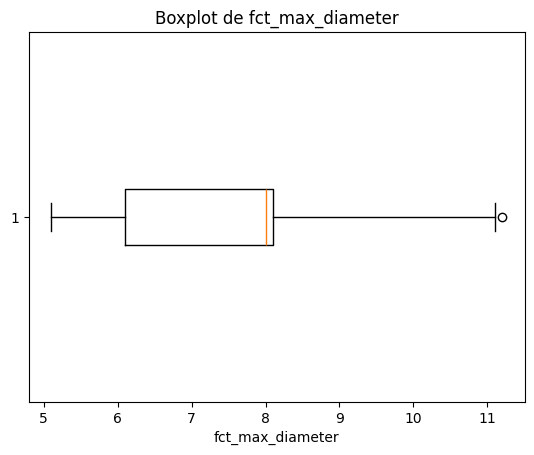

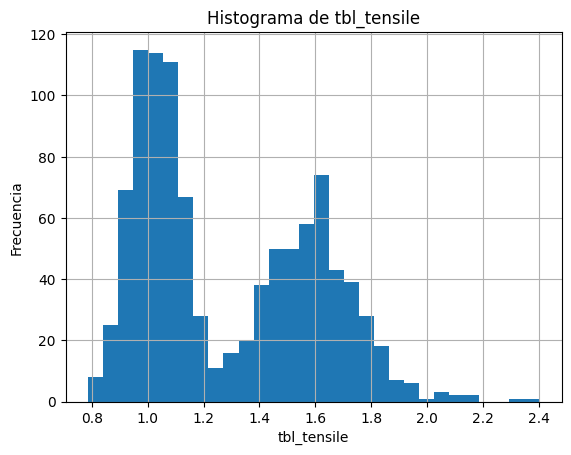

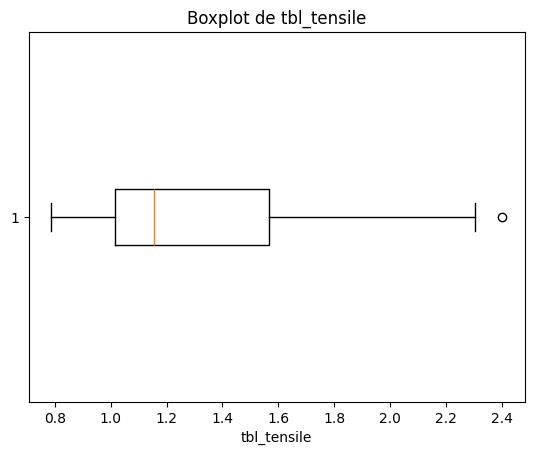

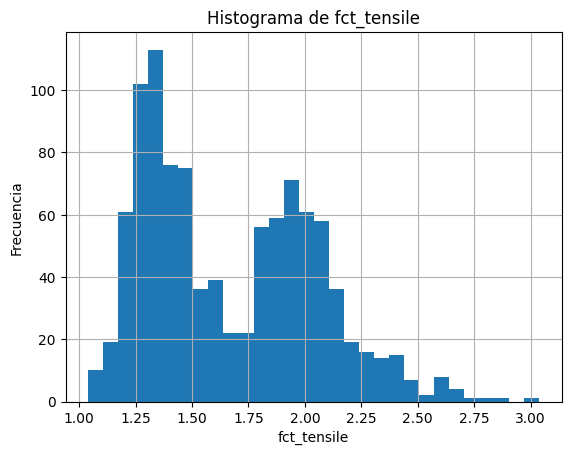

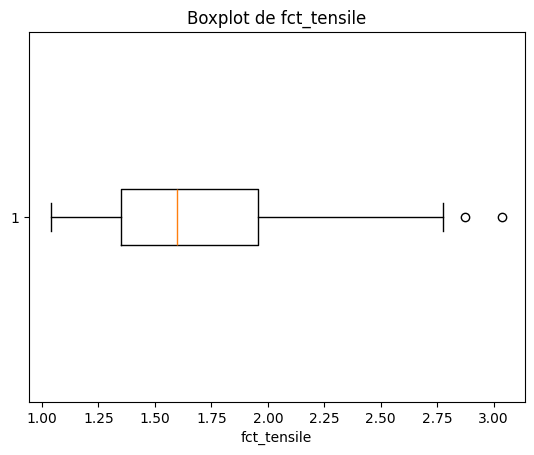

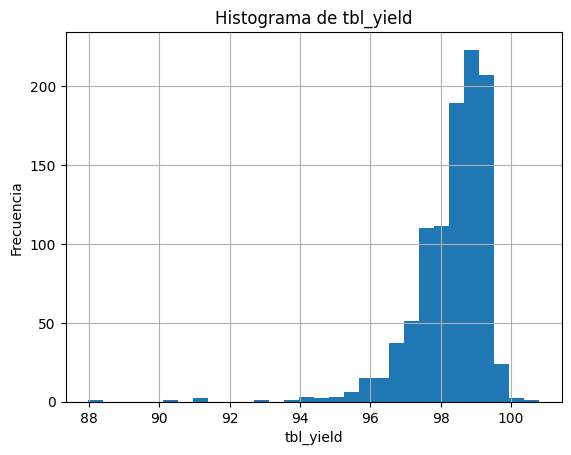

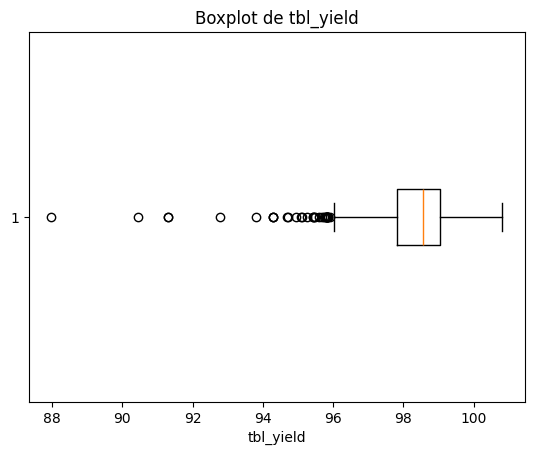

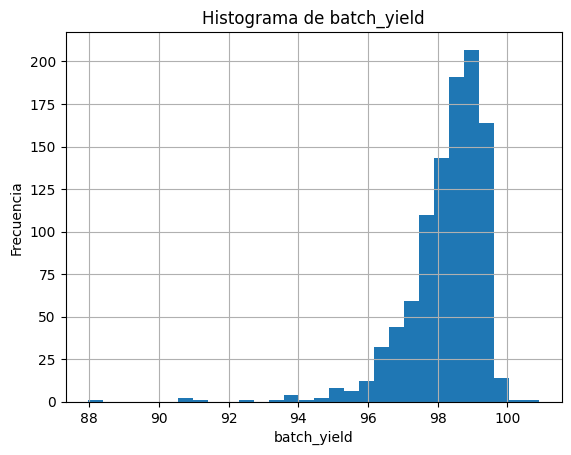

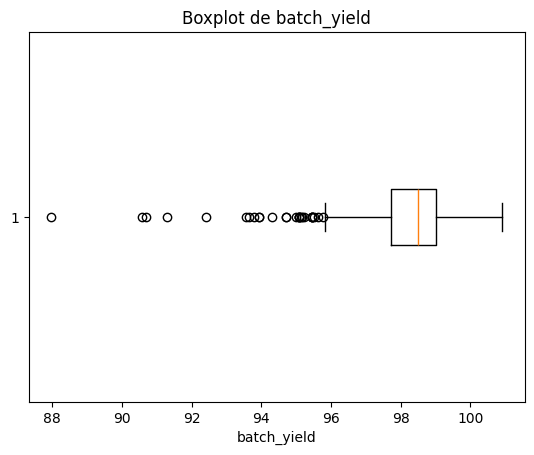

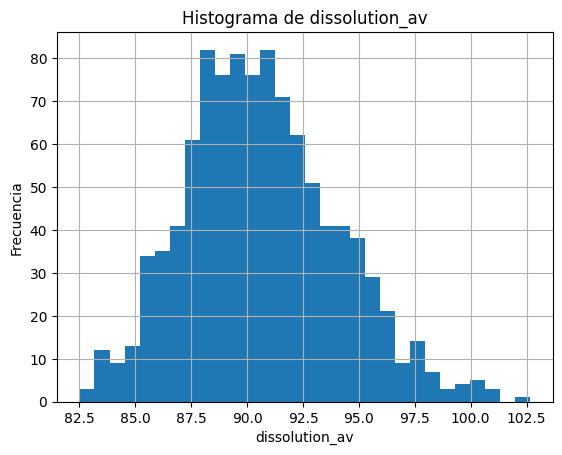

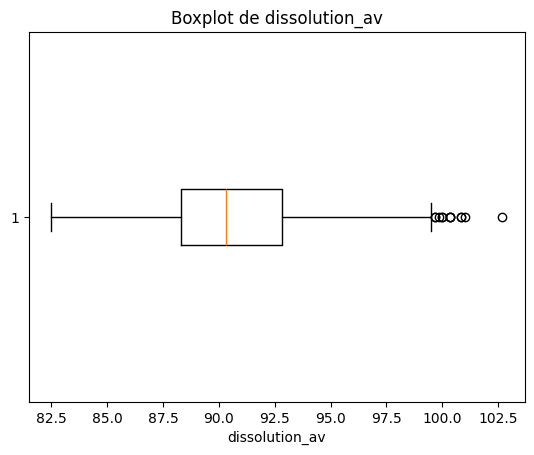

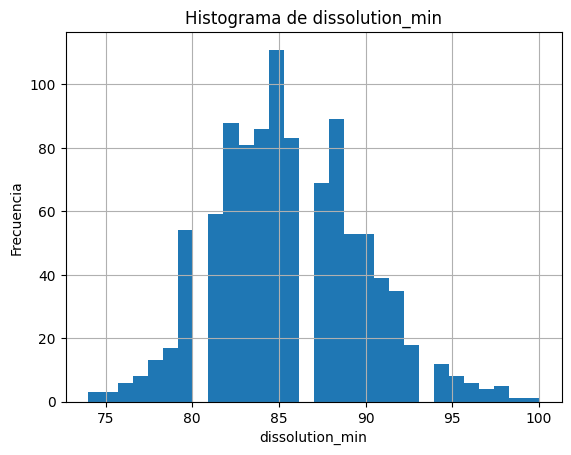

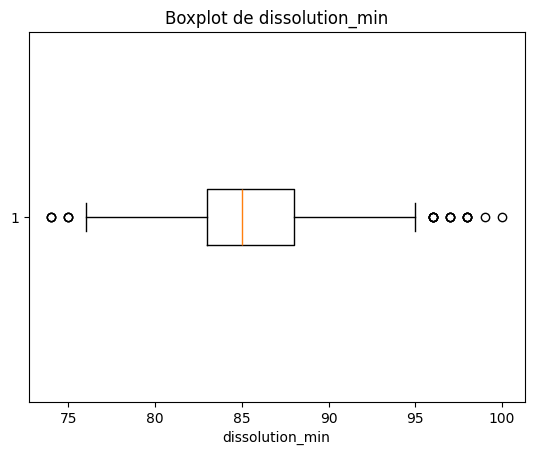

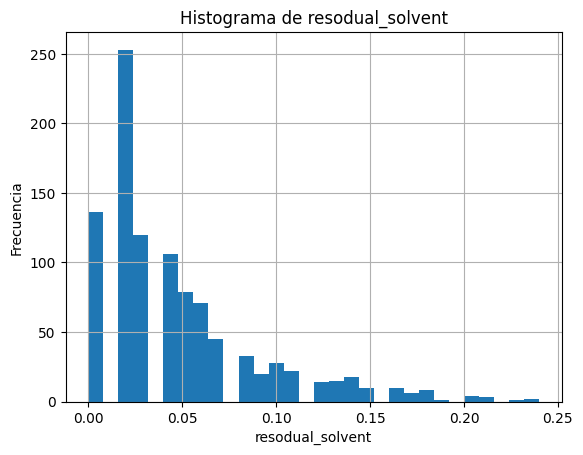

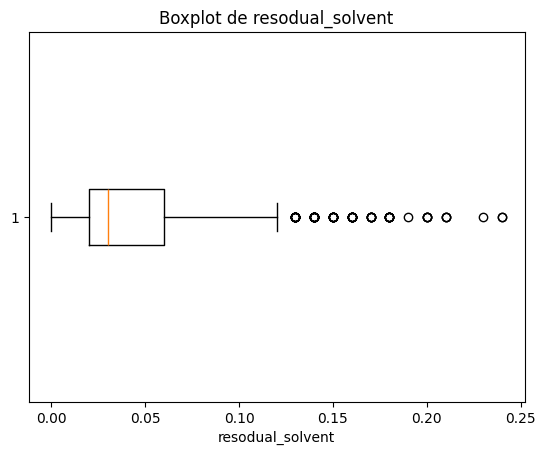

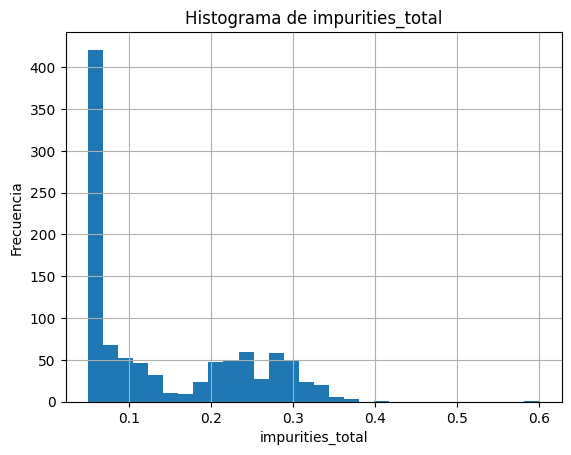

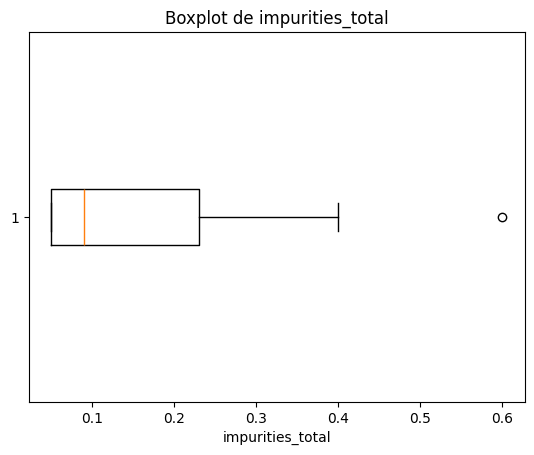

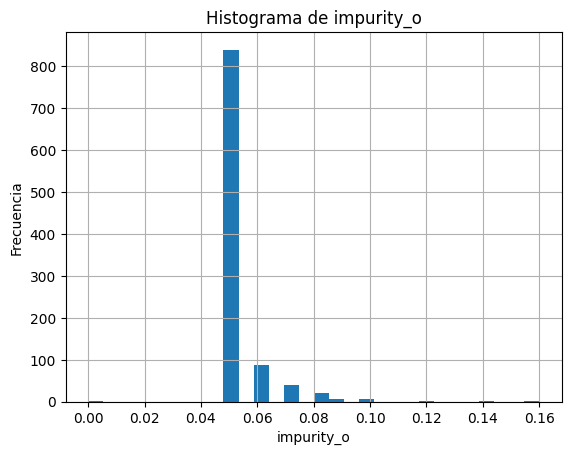

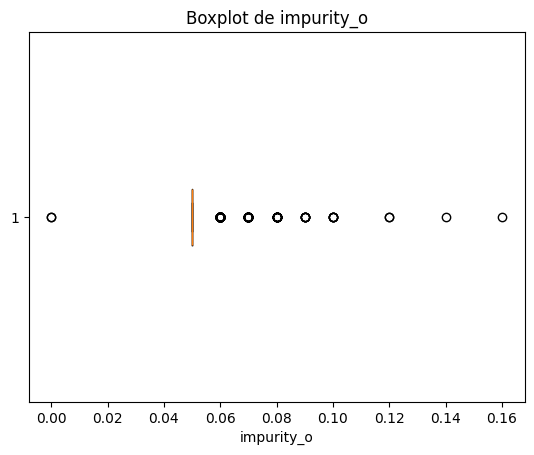

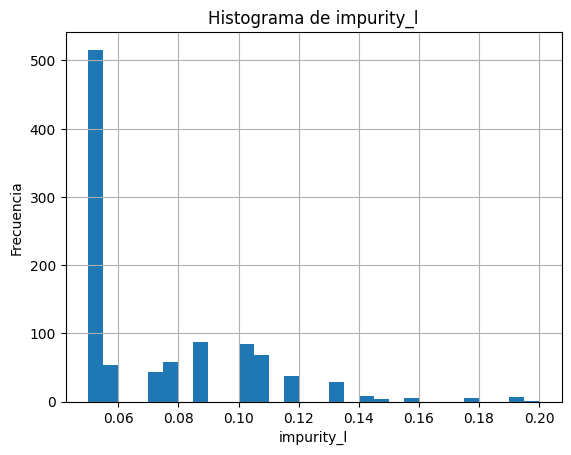

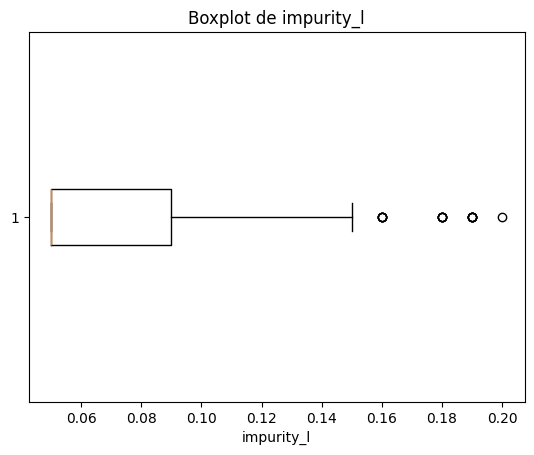

In [15]:
for col in numeric_cols[1:]:
    # Histograma
    plt.figure()
    df_pd[col].hist(bins=30)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

    # Boxplot
    plt.figure()
    plt.boxplot(df_pd[col].dropna(), vert=False)
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.show()

In [16]:
stats

,count,mean,std,min,p1,p5,50%,p95,p99,max
batch,1005.0,5.030000e+02,290.262812,1.000000,11.040000,51.200000,503.000000,9.548000e+02,9.949600e+02,1.005000e+03
code,1005.0,1.542388e+01,7.103071,1.000000,1.000000,1.000000,17.000000,2.300000e+01,2.500000e+01,2.500000e+01
size,1005.0,1.059290e+06,711428.568661,240000.000000,240000.000000,240000.000000,960000.000000,1.920000e+06,4.800000e+06,4.800000e+06
api_code,1005.0,3.377114e+00,1.352316,1.000000,1.000000,1.000000,3.000000,5.000000e+00,5.000000e+00,5.000000e+00
api_batch,1005.0,1.232567e+02,72.399262,1.000000,2.000000,8.000000,126.000000,2.390000e+02,2.520000e+02,2.540000e+02
smcc_batch,1005.0,9.252736e+00,5.113045,1.000000,1.000000,2.000000,9.000000,1.800000e+01,1.800000e+01,1.800000e+01
lactose_batch,1005.0,1.106269e+01,5.810508,1.000000,1.000000,3.000000,10.000000,2.000000e+01,2.200000e+01,2.200000e+01
starch_batch,1005.0,9.438806e+00,4.491635,1.000000,1.000000,2.000000,10.000000,1.600000e+01,1.700000e+01,1.700000e+01
api_content,1003.0,9.441805e+01,0.398930,93.300000,93.500000,93.800000,94.400000,9.510000e+01,9.550000e+01,9.560000e+01
lactose_water,1005.0,5.414945e-02,0.007891,0.049500,0.049500,0.049500,0.050000,8.000000e-02,8.000000e-02,8.000000e-02


In [17]:
outlier_info = {}
for col in numeric_cols:
    # Extraemos los percentiles como float usando .item() para garantizar un escalar
    p1 = stats.loc[col, 'p1']
    p99 = stats.loc[col, 'p99']
    # Conteo de valores fuera de rango
    below = int((df_pd[col] < p1).sum())
    above = int((df_pd[col] > p99).sum())
    outlier_info[col] = {'<p1': below, '>p99': above}

print("Conteo de outliers extremos por columna (por debajo de p1 / por encima de p99):")
print("Total rows: 1005")
for col, info in outlier_info.items():
    print(f"  {col}: {info['<p1']} / {info['>p99']}")


Conteo de outliers extremos por columna (por debajo de p1 / por encima de p99):
Total rows: 1005
  batch: 11 / 11
  code: 0 / 0
  size: 0 / 0
  api_code: 0 / 0
  api_batch: 2 / 9
  smcc_batch: 0 / 0
  lactose_batch: 0 / 0
  starch_batch: 0 / 0
  api_content: 7 / 4
  lactose_water: 0 / 0
  lactose_sieve0045: 0 / 0
  lactose_sieve015: 0 / 0
  lactose_sieve025: 0 / 0
  smcc_water: 0 / 0
  smcc_td: 0 / 0
  smcc_bd: 0 / 0
  smcc_ps01: 0 / 0
  smcc_ps05: 0 / 0
  smcc_ps09: 0 / 0
  starch_ph: 0 / 0
  starch_water: 0 / 0
  tbl_min_thickness: 3 / 0
  tbl_max_thickness: 0 / 0
  fct_min_thickness: 3 / 1
  fct_max_thickness: 0 / 0
  tbl_min_weight: 6 / 8
  tbl_max_weight: 8 / 8
  tbl_rsd_weight: 11 / 10
  fct_rsd_weight: 11 / 11
  tbl_min_hardness: 11 / 7
  tbl_max_hardness: 11 / 11
  tbl_av_hardness: 11 / 11
  fct_min_hardness: 11 / 8
  fct_max_hardness: 11 / 11
  fct_av_hardness: 6 / 11
  tbl_max_diameter: 3 / 6
  fct_max_diameter: 0 / 2
  tbl_tensile: 11 / 10
  fct_tensile: 11 / 11
  tbl_yield:

## 3. Consulta de especificaciones de calidad (Normas GMP)
En esta sección definimos los umbrales de calidad para etiquetar anomalías, basados en la Tabla 5 del artículo:

| Variable                      | Límite inferior | Límite superior | Unidad         |
|-------------------------------|-----------------|-----------------|----------------|
| dissolution_av (%)        | 85.5              | —               | %              |
| api_content (%)               | 93.6              | 95.5             | %              |
| impurities_total (%)          | —               | 0.35               | %              |



In [18]:
umbral_specs = {
    'dissolution_av': {'low': 80, 'high': None},
    'api_content': {'low': 95, 'high': 105},
    'impurities_total': {'low': None, 'high': 2}
}

# Verificación de los nombres disponibles
print("Variables disponibles para etiquetado:", numeric_cols)

Variables disponibles para etiquetado: ['batch', 'code', 'size', 'api_code', 'api_batch', 'smcc_batch', 'lactose_batch', 'starch_batch', 'api_content', 'lactose_water', 'lactose_sieve0045', 'lactose_sieve015', 'lactose_sieve025', 'smcc_water', 'smcc_td', 'smcc_bd', 'smcc_ps01', 'smcc_ps05', 'smcc_ps09', 'starch_ph', 'starch_water', 'tbl_min_thickness', 'tbl_max_thickness', 'fct_min_thickness', 'fct_max_thickness', 'tbl_min_weight', 'tbl_max_weight', 'tbl_rsd_weight', 'fct_rsd_weight', 'tbl_min_hardness', 'tbl_max_hardness', 'tbl_av_hardness', 'fct_min_hardness', 'fct_max_hardness', 'fct_av_hardness', 'tbl_max_diameter', 'fct_max_diameter', 'tbl_tensile', 'fct_tensile', 'tbl_yield', 'batch_yield', 'dissolution_av', 'dissolution_min', 'resodual_solvent', 'impurities_total', 'impurity_o', 'impurity_l']


### 4.1 Cálculo de proporciones fuera de rango

In [19]:
from pyspark.sql.functions import col, when, count

# Construir condiciones de fuera de spec
conditions = []
for var, limits in umbral_specs.items():
    if limits['low'] is not None:
        conditions.append(when(col(var) < limits['low'], 1).otherwise(0).alias(f"{var}_below"))
    if limits['high'] is not None:
        conditions.append(when(col(var) > limits['high'], 1).otherwise(0).alias(f"{var}_above"))


# Aplicar a df_lab
df_flags = df_lab.select(*conditions)
summary_flags = df_flags.agg(*[count(when(col(c)==1, True)).alias(c) for c in df_flags.columns])
summary_flags.show()

# Calcular proporción relativa
total_count = df_lab.count()
print(f"Total registros: {total_count}")
summary_flags.toPandas().apply(lambda x: x/total_count)

+--------------------+-----------------+-----------------+----------------------+
|dissolution_av_below|api_content_below|api_content_above|impurities_total_above|
+--------------------+-----------------+-----------------+----------------------+
|                   0|              897|                0|                     0|
+--------------------+-----------------+-----------------+----------------------+

Total registros: 1005


,dissolution_av_below,api_content_below,api_content_above,impurities_total_above
0,0.0,0.892537,0.0,0.0


### 4.2 Visualización con umbrales

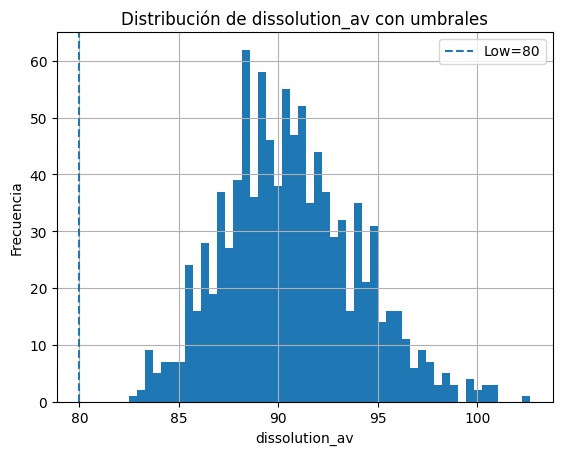

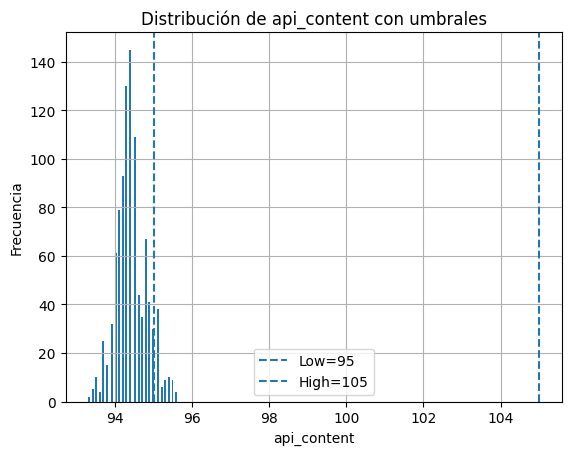

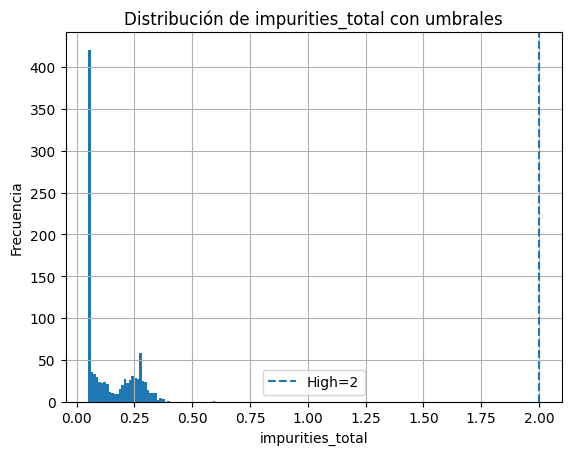

In [20]:
import matplotlib.pyplot as plt

for var, limits in umbral_specs.items():
    plt.figure()
    df_pd[var].hist(bins=50)
    if limits['low'] is not None:
        plt.axvline(limits['low'], linestyle='--', label=f"Low={limits['low']}")
    if limits['high'] is not None:
        plt.axvline(limits['high'], linestyle='--', label=f"High={limits['high']}")
    plt.title(f"Distribución de {var} con umbrales")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.show()



### 4.3 Análisis de percentiles cercanos a límites

In [21]:
percentiles = [0.01, 0.05, 0.1, 0.9, 0.95, 0.99]
percentile_stats = df_pd[numeric_cols].quantile(percentiles)
percentile_stats.index = [f"p{int(p*100)}" for p in percentiles]
percentile_stats.loc[["p5", "p95"]]

,batch,code,size,api_code,api_batch,smcc_batch,lactose_batch,starch_batch,api_content,lactose_water,...,tbl_tensile,fct_tensile,tbl_yield,batch_yield,dissolution_av,dissolution_min,resodual_solvent,impurities_total,impurity_o,impurity_l
p5,51.2,1.0,240000.0,1.0,8.0,2.0,3.0,2.0,93.8,0.0495,...,0.912692,1.194770,96.5506,96.319,85.5,80.0,0.00,0.05,0.05,0.05
p95,954.8,23.0,1920000.0,5.0,239.0,18.0,20.0,16.0,95.1,0.0800,...,1.791401,2.316325,99.4310,99.432,96.5,93.0,0.14,0.31,0.07,0.13


In [22]:
from pyspark.sql.functions import col, when, greatest, max as spark_max


In [23]:
umbral_specs = {
    'dissolution_av': {'low': 85.51, 'high': None},
    'api_content': {'low': 93.80, 'high': 95.49},
    'impurities_total': {'low': None, 'high': 0.349}
}

In [24]:
df_flagged = df_lab
for var, limits in umbral_specs.items():
    if limits['low'] is not None:
        df_flagged = df_flagged.withColumn(f"{var}_below", when(col(var) < limits['low'], 1).otherwise(0))
    if limits['high'] is not None:
        df_flagged = df_flagged.withColumn(f"{var}_above", when(col(var) > limits['high'], 1).otherwise(0))

# Combinar flags por fila (si alguno es 1)
flag_cols = [c for c in df_flagged.columns if c.endswith('_below') or c.endswith('_above')]
df_flagged = df_flagged.withColumn("is_anomalous_row", greatest(*[col(c) for c in flag_cols]))

In [41]:
# Número de batches distintos
num_batches = df_flagged.select("batch").distinct().count()

# Número total de filas
num_rows = df_flagged.count()

print(f"Número de batches distintos: {num_batches}")
print(f"Número total de filas: {num_rows}")


Número de batches distintos: 1005
Número total de filas: 1005


In [45]:
# Agregar por lote
df_labeled = (
    df_flagged.withColumnRenamed("is_anomalous_row", "is_anomalous")
)


In [46]:

# Mostrar ejemplo
df_labeled.show(10)

+-----+----+--------+------+------+--------+---------+----------+-------------+------------+---------+--------------------+--------------+-----------+--------+--------+--------+-------------+-----------------+----------------+----------------+----------+-------+-------+---------+---------+---------+---------+------------+-----------------+-----------------+-----------------+-----------------+--------------+--------------+--------------+--------------+----------------+----------------+---------------+----------------+----------------+---------------+----------------+----------------+-----------+-----------+---------+-----------+--------------+---------------+----------------+----------------+----------+----------+--------------------+-----------------+-----------------+----------------------+------------+
|batch|code|strength|  size| start|api_code|api_batch|smcc_batch|lactose_batch|starch_batch|api_water|api_total_impurities|api_l_impurity|api_content|api_ps01|api_ps05|api_ps09|lactose

In [35]:
df_labeled

DataFrame[batch: int, is_anomalous: int]

In [47]:
df_labeled.groupBy("is_anomalous").count().show()


[Stage 227:>                                                        (0 + 1) / 1]

+------------+-----+
|is_anomalous|count|
+------------+-----+
|           1|  118|
|           0|  887|
+------------+-----+



In [48]:
anomalous_ratio = df_labeled.filter("is_anomalous == 1").count() / df_labeled.count()
print(f"Proporción de anomalías: {anomalous_ratio:.2%}")


Proporción de anomalías: 11.74%


In [49]:
output_path=f's3a://{env_aux["bucket_name"]}/{env_aux["prefix_output"]}/laboratory_labeled.parquet'
output_path

's3a://anomaly-pharma-bucket/data/interim/laboratory_labeled.parquet'

In [50]:
df_labeled.write \
    .mode("overwrite") \
    .parquet(output_path)